In [1]:
#Importing Libraries
import os
import numpy as np

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import load_img, ImageDataGenerator
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten


In [2]:
#Fetch Images count from Fodlers

count = 0 
dirs = os.listdir('Images/')
for dir in dirs:
    files = list(os.listdir('Images/'+dir))
    print( dir +' Folder has '+ str(len(files)) + ' Images')
    count = count + len(files)
print( 'Images Folder has '+ str(count) + ' Images')

daisy Folder has 764 Images
dandelion Folder has 1052 Images
rose Folder has 784 Images
sunflower Folder has 733 Images
tulip Folder has 984 Images
Images Folder has 4317 Images


In [3]:
#Load Images into Arrays as Dataset

base_dir = 'Images/'
img_size = 180
batch = 32

In [4]:
train_ds = tf.keras.utils.image_dataset_from_directory( base_dir,
                                                       seed = 123,
                                                       validation_split=0.2,
                                                       subset = 'training',
                                                       batch_size=batch,
                                                       image_size=(img_size,img_size))

val_ds = tf.keras.utils.image_dataset_from_directory( base_dir,
                                                       seed = 123,
                                                       validation_split=0.2,
                                                       subset = 'validation',
                                                       batch_size=batch,
                                                       image_size=(img_size,img_size))

Found 4317 files belonging to 5 classes.
Using 3454 files for training.
Found 4317 files belonging to 5 classes.
Using 863 files for validation.


In [5]:
flower_names = train_ds.class_names
flower_names

['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']

In [6]:
import matplotlib.pyplot as plt

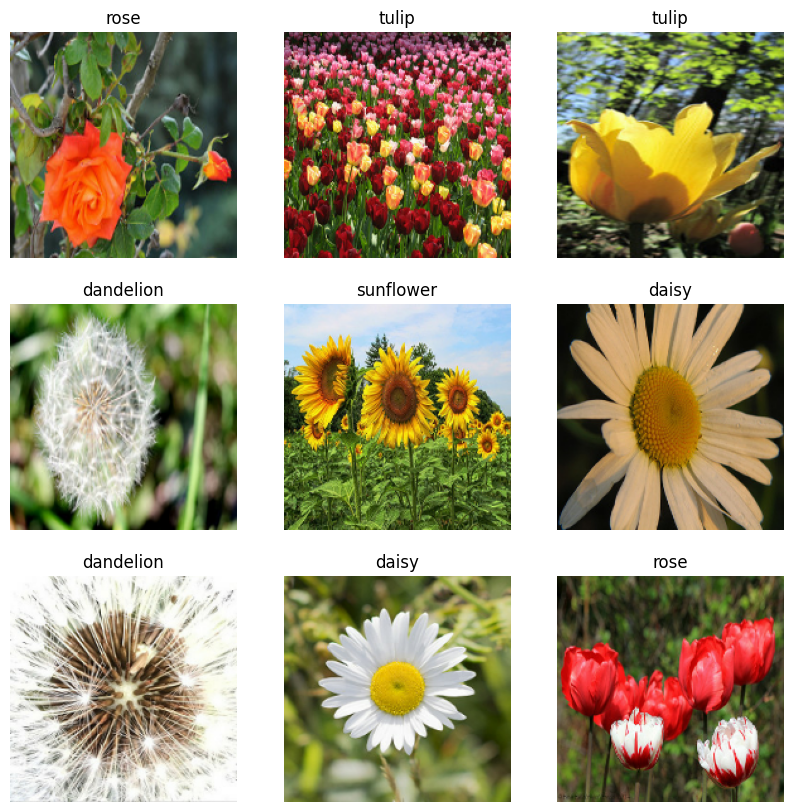

In [7]:
i = 0
plt.figure(figsize=(10,10))

for images, labels in train_ds.take(1):
    for i in range(9):
        plt.subplot(3,3, i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(flower_names[labels[i]])
        plt.axis('off')

In [8]:
AUTOTUNE = tf.data.AUTOTUNE

In [9]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = AUTOTUNE)

In [10]:
val_ds = val_ds.cache().prefetch(buffer_size = AUTOTUNE)

In [11]:
#Data Augmentation

data_augmentation = Sequential([
    layers.RandomFlip("horizontal", input_shape = (img_size,img_size,3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1)
])

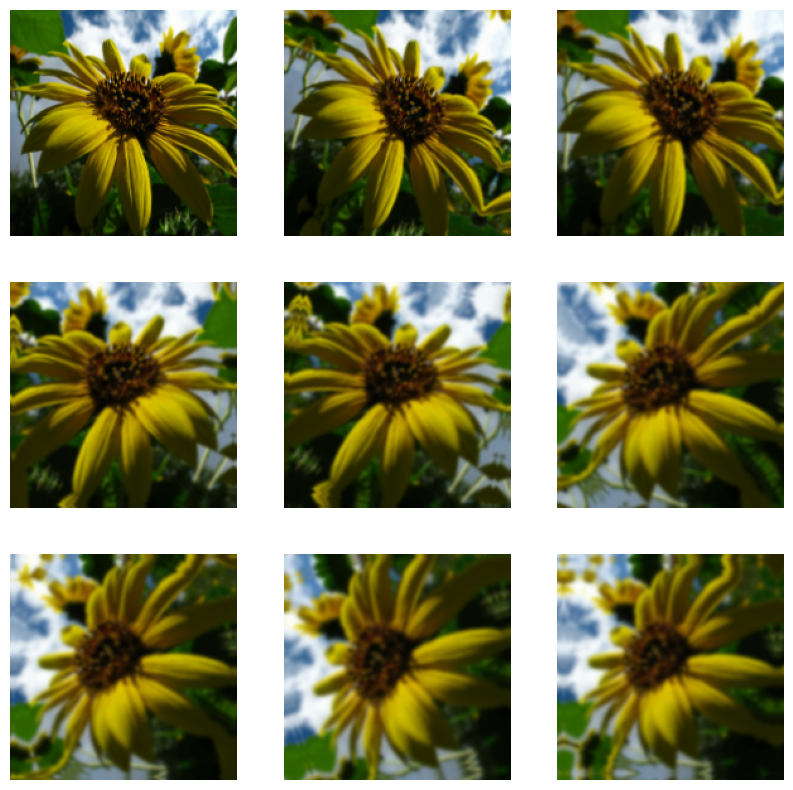

In [13]:
i = 0
plt.figure(figsize=(10,10))

for images, labels in train_ds.take(1):
    for i in range(9):
        images = data_augmentation(images)
        plt.subplot(3,3, i+1)
        plt.imshow(images[0].numpy().astype('uint8'))
        plt.axis('off')

In [14]:
#Model Creation

model = Sequential([
    data_augmentation,
    layers.Rescaling(1./255),
    Conv2D(16, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Dropout(0.2),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(5)
])

In [15]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [16]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 180, 180, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 90, 90, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 45, 45, 32)        0         
 g2D)                                                 

In [17]:
history = model.fit(train_ds, epochs=15, validation_data=val_ds)

Epoch 1/15
108/108 [==============================] - 101s 901ms/step - loss: 1.2451 - accuracy: 0.4800 - val_loss: 1.0276 - val_accuracy: 0.5643
Epoch 2/15
108/108 [==============================] - 85s 791ms/step - loss: 1.0160 - accuracy: 0.6048 - val_loss: 0.9773 - val_accuracy: 0.6188
Epoch 3/15
108/108 [==============================] - 106s 981ms/step - loss: 0.9001 - accuracy: 0.6506 - val_loss: 0.9022 - val_accuracy: 0.6396
Epoch 4/15
108/108 [==============================] - 106s 984ms/step - loss: 0.8339 - accuracy: 0.6752 - val_loss: 0.8882 - val_accuracy: 0.6489
Epoch 5/15
108/108 [==============================] - 109s 1s/step - loss: 0.7902 - accuracy: 0.6966 - val_loss: 0.8294 - val_accuracy: 0.6848
Epoch 6/15
108/108 [==============================] - 108s 1s/step - loss: 0.7507 - accuracy: 0.7053 - val_loss: 0.8786 - val_accuracy: 0.6628
Epoch 7/15
108/108 [==============================] - 116s 1s/step - loss: 0.7159 - accuracy: 0.7238 - val_loss: 0.7625 - val_accur

In [18]:
def classify_images(image_path):
    input_image = tf.keras.utils.load_img(image_path, target_size=(180,180))
    input_image_array = tf.keras.utils.img_to_array(input_image)
    input_image_exp_dim = tf.expand_dims(input_image_array,0)

    predictions = model.predict(input_image_exp_dim)
    result = tf.nn.softmax(predictions[0])
    outcome = 'The Image belongs to ' + flower_names[np.argmax(result)] + ' with a score of '+ str(np.max(result)*100)
    return outcome

In [19]:
classify_images('Sample/daisy.jpg')

1/1 [==============================] - 2s 2s/step


'The Image belongs to daisy with a score of 99.99864101409912'

In [20]:
model.save('Flower_Recog_Model.h5')

D:\python3\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
